In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [8]:
def monte_carlo_call(S0, K, T, r, sigma, n_sim):
    Z = np.random.randn(n_sim)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    return np.exp(-r * T) * payoff.mean()

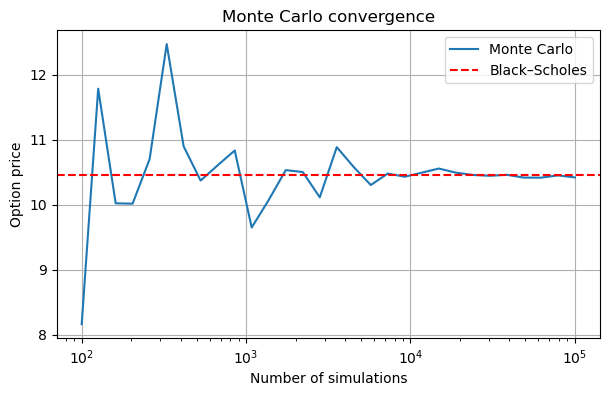

In [9]:
S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
bs_price = black_scholes_call(S0, K, T, r, sigma)

ns = np.logspace(2, 5, 30).astype(int)
mc_prices = []

for n in ns:
    mc_prices.append(monte_carlo_call(S0, K, T, r, sigma, n))

plt.figure(figsize=(7,4))
plt.semilogx(ns, mc_prices, label="Monte Carlo")
plt.axhline(bs_price, color="red", linestyle="--", label="Black–Scholes")
plt.xlabel("Number of simulations")
plt.ylabel("Option price")
plt.title("Monte Carlo convergence")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def sample_parameters(n):
    S0 = np.random.uniform(50, 150, n)
    K = np.random.uniform(50, 150, n)
    T = np.random.uniform(0.1, 2.0, n)
    r = np.random.uniform(0.0, 0.1, n)
    sigma = np.random.uniform(0.1, 0.5, n)
    return np.stack([S0, K, T, r, sigma], axis=1)

In [ ]:
def generate_dataset(n_samples, mc_sims):
    X = sample_parameters(n_samples)
    y = []

    for params in X:
        price = monte_carlo_call(*params, n_sim=mc_sims)
        y.append(price)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [12]:
X_train, y_train = generate_dataset(
    n_samples=50000,
    mc_sims=200000
)

In [3]:
class PricingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PricingNet()

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 128
batch_size = 128

for epoch in range(epochs):
    perm = torch.randperm(len(X_train))

    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = X_train[idx], y_train[idx]

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | MSE {epoch_loss:.6f}")


Epoch 000 | MSE 29605.242370
Epoch 005 | MSE 3750.881783
Epoch 010 | MSE 1739.915438
Epoch 015 | MSE 1391.963572
Epoch 020 | MSE 1175.361554
Epoch 025 | MSE 970.736202
Epoch 030 | MSE 820.193534
Epoch 035 | MSE 683.871599
Epoch 040 | MSE 630.800915
Epoch 045 | MSE 553.220048
Epoch 050 | MSE 513.739502
Epoch 055 | MSE 512.401009
Epoch 060 | MSE 476.715885
Epoch 065 | MSE 480.637150
Epoch 070 | MSE 449.143664
Epoch 075 | MSE 442.108339
Epoch 080 | MSE 471.887765
Epoch 085 | MSE 447.736099
Epoch 090 | MSE 426.040061
Epoch 095 | MSE 408.839944
Epoch 100 | MSE 422.324361
Epoch 105 | MSE 389.082319
Epoch 110 | MSE 359.246656
Epoch 115 | MSE 249.185210
Epoch 120 | MSE 161.960045
Epoch 125 | MSE 127.546958


In [15]:
model.eval()

test_params = np.array([[100, 100, 1.0, 0.05, 0.2]])
test_tensor = torch.tensor(test_params, dtype=torch.float32)

nn_price = model(test_tensor).item()
bs_price = black_scholes_call(*test_params[0])

print(f"Neural Net Price: {nn_price:.4f}")
print(f"Black–Scholes Price: {bs_price:.4f}")


Neural Net Price: 10.4789
Black–Scholes Price: 10.4506


In [16]:
import time
import numpy as np

n_runs = 1000

mc_times = []
nn_times = []

for _ in range(n_runs):
    start = time.time()
    monte_carlo_call(100, 100, 1, 0.05, 0.2, 100000)
    mc_times.append(time.time() - start)

    start = time.time()
    model(test_tensor)
    nn_times.append(time.time() - start)

mc_times = np.array(mc_times)
nn_times = np.array(nn_times)

mc_mean = mc_times.mean()
mc_var  = mc_times.var()

nn_mean = nn_times.mean()
nn_var  = nn_times.var()

speedup_mean = mc_times / nn_times


In [17]:
print(f"MC mean: {mc_mean:.6f}, MC var: {mc_var:.6f}")
print(f"NN mean: {nn_mean:.6f}, NN var: {nn_var:.6f}")
print("Speedup mean:", speedup_mean.mean())

MC mean: 0.001500, MC var: 0.000000
NN mean: 0.000019, NN var: 0.000000
Speedup mean: 79.63778660747106


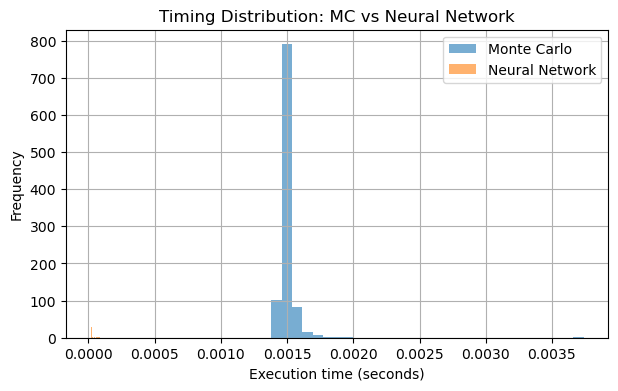

In [18]:
plt.figure(figsize=(7,4))
plt.hist(mc_times, bins=30, alpha=0.6, label="Monte Carlo")
plt.hist(nn_times, bins=30, alpha=0.6, label="Neural Network")
plt.xlabel("Execution time (seconds)")
plt.ylabel("Frequency")
plt.title("Timing Distribution: MC vs Neural Network")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
help(PricingNet)

Help on class PricingNet in module __main__:

class PricingNet(torch.nn.modules.module.Module)
 |  Method resolution order:
 |      PricingNet
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, x)
 |      Define the computation performed at every call.
 |      
 |      Should be overridden by all subclasses.
 |      
 |      .. note::
 |          Although the recipe for forward pass needs to be defined within
 |          this function, one should call the :class:`Module` instance afterwards
 |          instead of this since the former takes care of running the
 |          registered hooks while the latter silently ignores them.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  --------------------------